In [19]:
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import UnitaryGate
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram
from math import sin, asin, floor, sqrt, pi
import numpy as np
from scipy.linalg import sqrtm, fractional_matrix_power
from qiskit.circuit.library import RXGate
import matplotlib.pyplot as plt
from qiskit.quantum_info import Operator
from scipy.linalg import fractional_matrix_power


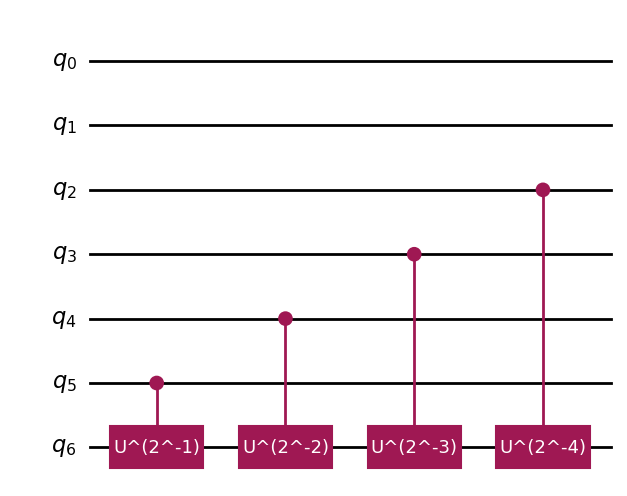

In [8]:
def P(n: int, U) -> QuantumCircuit:
    qc = QuantumCircuit(n + 2)
    for k in reversed(range(2, n + 1)):
        U = sqrtm(U)
        cu_gate = UnitaryGate(U, label=f"U^(2^-{n - k + 1})").control(1)
        qc.append(cu_gate, [k, n + 1])

    return qc

U = np.array([
    [1, 0],
    [0, -1]
])

P(5, U).draw(output="mpl")

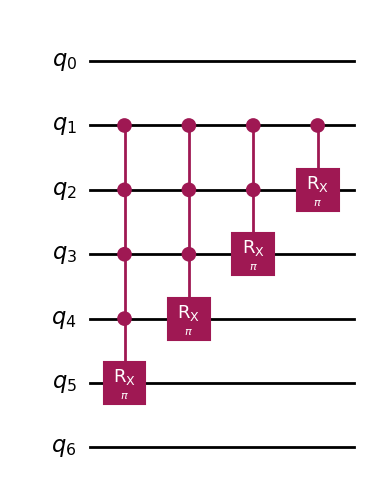

In [23]:
def Q(n: int) -> QuantumCircuit:
    qc = QuantumCircuit(n + 2)
    for k in reversed(range(1, n)):
        qc.append(RXGate(pi).control(k), range(1, k + 2))
    
    return qc

Q(5).draw(output="mpl")